In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from datetime import timedelta
from matplotlib.ticker import MultipleLocator

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor

from sklearn import model_selection, preprocessing, metrics, tree
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import make_scorer , confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.svm import SVR

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

seed_val = 42

/kaggle/dev/jovan/mercedes-benz-greener-manufacturing/venv-mercedes/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# constants
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data/'
SUBMISSION_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions'

In [3]:
# loading the data
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# reseting index
train = train.set_index('ID')
test = test.set_index('ID')

In [4]:
col_std = pd.DataFrame(train.std(axis=0)).reset_index()
col_std.columns = ['col_name', 'col_std']

col_mean = pd.DataFrame(train.mean(axis=0)).reset_index()
col_mean.columns = ['col_name', 'col_mean']

col_analyzer = pd.merge(col_std, col_mean, how='inner', on='col_name')

In [5]:
col_analyzer[(col_analyzer['col_std']==0) & (col_analyzer['col_mean']==0)]

,col_name,col_std,col_mean
2,X11,0.0,0.0
82,X93,0.0,0.0
96,X107,0.0,0.0
218,X233,0.0,0.0
220,X235,0.0,0.0
253,X268,0.0,0.0
274,X289,0.0,0.0
275,X290,0.0,0.0
278,X293,0.0,0.0
282,X297,0.0,0.0


remove these above columns

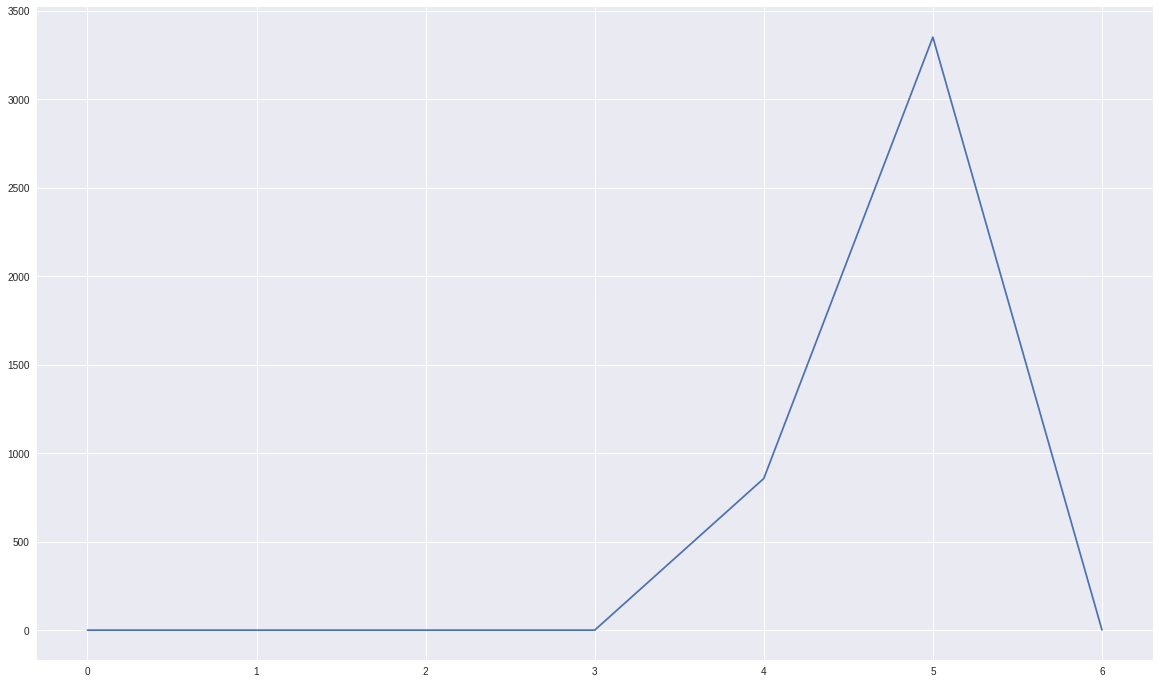

In [6]:
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(np.bincount(np.round(np.log(train.y.values)).astype('int')))
plt.show()

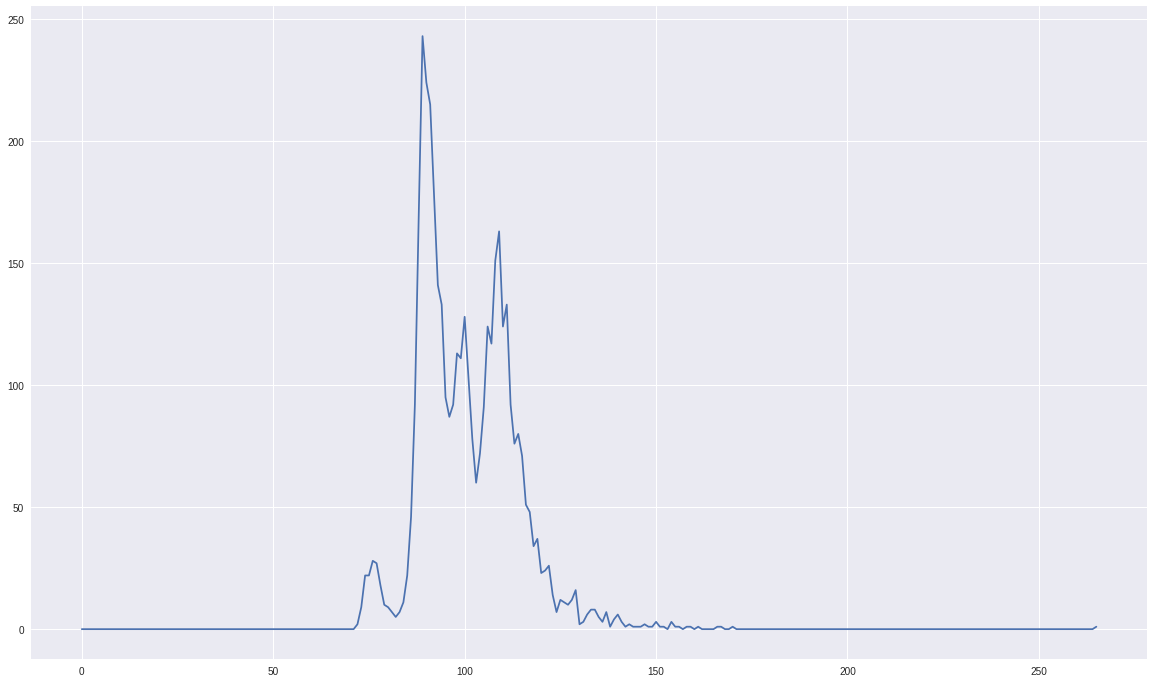

In [7]:
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(np.bincount(np.round(train.y.values).astype('int')))
plt.show()

In [8]:
temp  = pd.DataFrame(np.bincount(np.round(train.y.values).astype('int'))).reset_index()
temp.columns = ['index', 'bincount']
temp[temp['bincount']>0].sort_values('bincount', ascending=False).head(60)

,index,bincount
89,89,243
90,90,224
91,91,215
92,92,178
88,88,169
109,109,163
108,108,151
93,93,141
94,94,133
111,111,133


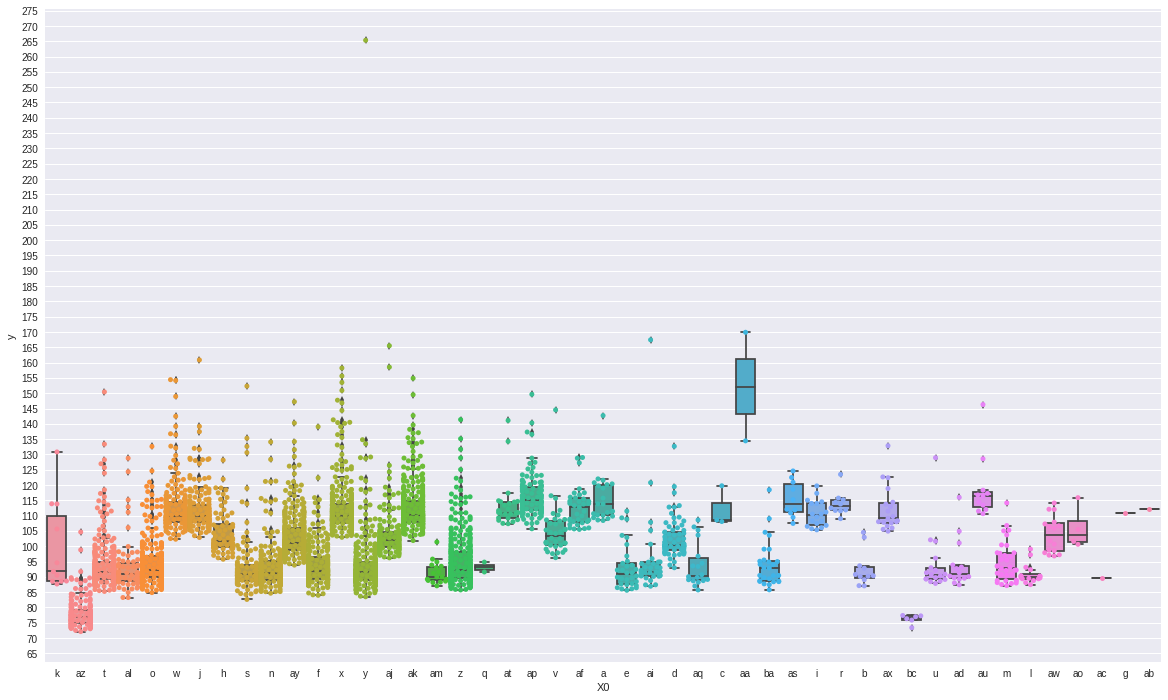

In [9]:
majorLocator = MultipleLocator(5) 

fig, ax = plt.subplots(figsize=(20,12))
sns.swarmplot(train['X0'], train['y'])
sns.boxplot(train['X0'], train['y'])
ax.yaxis.set_major_locator(majorLocator)

In [10]:
X0_buckets = train.groupby(['X0'])['y'].median().reset_index().sort_values(['y'], ascending='True')
print('group 0:', X0_buckets[X0_buckets['y']<80].X0.values)
print('group 1:', X0_buckets[(X0_buckets['y']>80) & (X0_buckets['y']<96)].X0.values)
print('group 2:', X0_buckets[(X0_buckets['y']>96) & (X0_buckets['y']<103)].X0.values)
print('group 3:', X0_buckets[(X0_buckets['y']>103)].X0.values)

group 0: ['bc' 'az']
group 1: ['ac' 'am' 'l' 'b' 'aq' 'u' 'ad' 'e' 'al' 's' 'n' 'y' 't' 'ai' 'k' 'f' 'z'
 'o' 'ba' 'm' 'q']
group 2: ['d' 'ay' 'h' 'aj']
group 3: ['v' 'ao' 'aw' 'c' 'ax' 'x' 'j' 'w' 'i' 'ak' 'g' 'at' 'ab' 'af' 'r' 'as'
 'a' 'ap' 'au' 'aa']


In [11]:
train.X0.unique()

array(['k', 'az', 't', 'al', 'o', 'w', 'j', 'h', 's', 'n', 'ay', 'f', 'x',
       'y', 'aj', 'ak', 'am', 'z', 'q', 'at', 'ap', 'v', 'af', 'a', 'e',
       'ai', 'd', 'aq', 'c', 'aa', 'ba', 'as', 'i', 'r', 'b', 'ax', 'bc',
       'u', 'ad', 'au', 'm', 'l', 'aw', 'ao', 'ac', 'g', 'ab'], dtype=object)

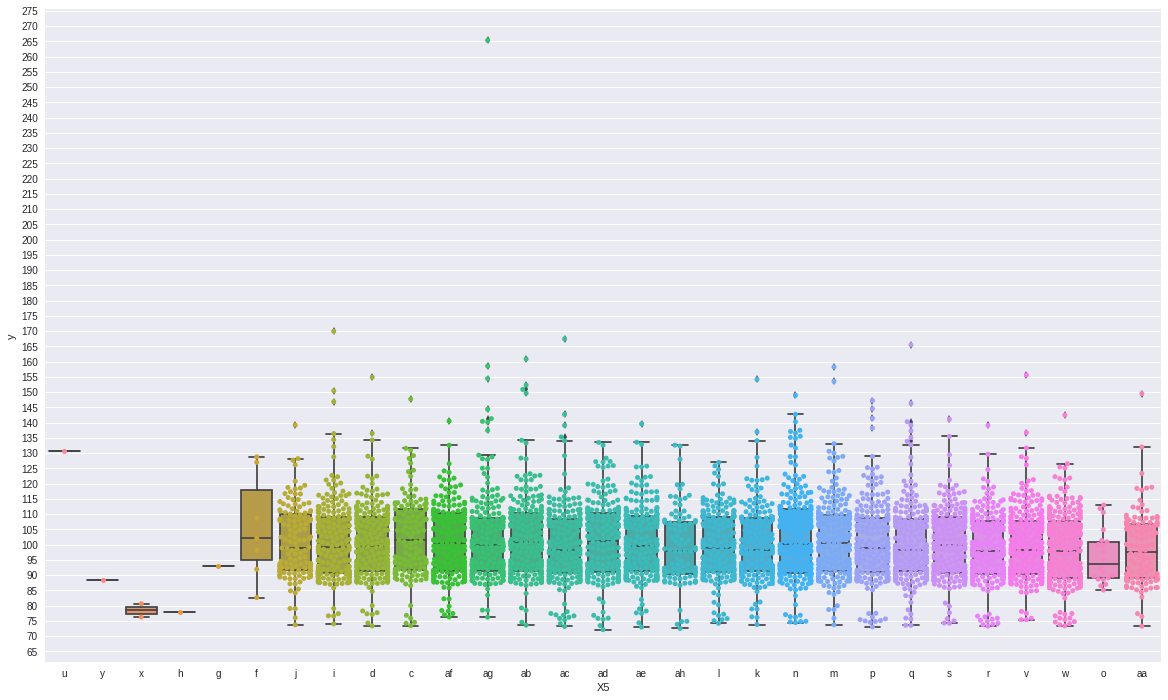

In [12]:
majorLocator = MultipleLocator(5) 

fig, ax = plt.subplots(figsize=(20,12))
sns.swarmplot(train['X5'], train['y'])
sns.boxplot(train['X5'], train['y'])
ax.yaxis.set_major_locator(majorLocator)

In [13]:
X5_buckets = train.groupby(['X5'])['y'].median().reset_index().sort_values(['y'], ascending='True')
print('group 0:', X5_buckets[X5_buckets['y']<80].X5.values)
print('group 1:', X5_buckets[(X5_buckets['y']>80) & (X5_buckets['y']<96)].X5.values)
print('group 2:', X5_buckets[(X5_buckets['y']>96) & (X5_buckets['y']<103)].X5.values)
print('group 3:', X5_buckets[(X5_buckets['y']>103)].X5.values)

group 0: ['h' 'x']
group 1: ['y' 'g' 'o']
group 2: ['aa' 'r' 'ah' 'w' 'k' 'ac' 'v' 'q' 'l' 'j' 'p' 'i' 'd' 'ae' 'ag' 's' 'n'
 'm' 'af' 'ab' 'ad' 'c' 'f']
group 3: ['u']


In [14]:
#train.T.drop_duplicates().T.columns

In [15]:
# X0 groups
train['eng1_X0_group'] = train[['X0']].apply(lambda x: 0 if x['X0'] in ['bc', 'az']
                                       else 1 if x['X0']  in ['ac', 'am', 'l', 'b', 'aq', 'u', 'ad', 'e', 
                                                                 'al', 's', 'n', 'y', 't', 'ai', 'k', 'f', 'z', 
                                                                 'o', 'ba', 'm', 'q']
                                       else 2 if x['X0'] in ['d', 'ay', 'h', 'aj']
                                       else 3 if x['X0'] in ['v', 'ao', 'aw', 'c', 'ax', 'x', 'j', 'w', 'i',
                                                                'ak', 'g', 'at', 'ab', 'af', 'r', 'as', 'a', 'ap',
                                                                'au', 'aa']
                                       else -1, axis=1)

test['eng1_X0_group'] = test[['X0']].apply(lambda x: 0 if x['X0'] in ['bc', 'az']
                                       else 1 if x['X0']  in ['ac', 'am', 'l', 'b', 'aq', 'u', 'ad', 'e', 
                                                                 'al', 's', 'n', 'y', 't', 'ai', 'k', 'f', 'z', 
                                                                 'o', 'ba', 'm', 'q']
                                       else 2 if x['X0'] in ['d', 'ay', 'h', 'aj']
                                       else 3 if x['X0'] in ['v', 'ao', 'aw', 'c', 'ax', 'x', 'j', 'w', 'i',
                                                                'ak', 'g', 'at', 'ab', 'af', 'r', 'as', 'a', 'ap',
                                                                'au', 'aa']
                                       else -1, axis=1)



#X0_group 2
train['eng1_X0_group_2'] = train[['X127', 'X118', 'X238']].apply(lambda x: 0 if(x['X127']==0 and x['X118']==0 and x['X238']==0)
                                                             else 1 if(x['X127']==1)
                                                             else 2 if(x['X127']==0 and x['X118']==0 and x['X238']==1)
                                                             else 3 if(x['X127']==0 and x['X118']==1)
                                                             else -1, axis=1)

test['eng1_X0_group_2'] = test[['X127', 'X118', 'X238']].apply(lambda x: 0 if(x['X127']==0 and x['X118']==0 and x['X238']==0)
                                                             else 1 if(x['X127']==1)
                                                             else 2 if(x['X127']==0 and x['X118']==0 and x['X238']==1)
                                                             else 3 if(x['X127']==0 and x['X118']==1)
                                                             else -1, axis=1)

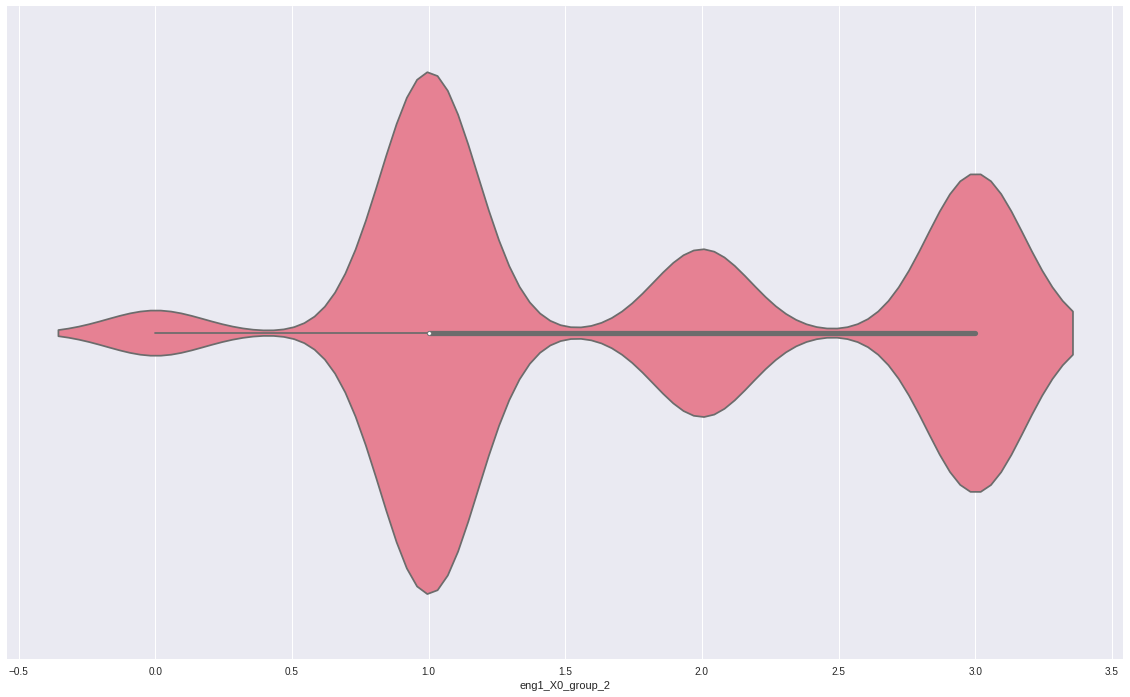

In [16]:
majorLocator = MultipleLocator(1) 
fig, ax = plt.subplots(figsize=(20,12))
ax.yaxis.set_major_locator(majorLocator)
sns.set_palette("husl")
sns.violinplot(x = train['eng1_X0_group_2'])

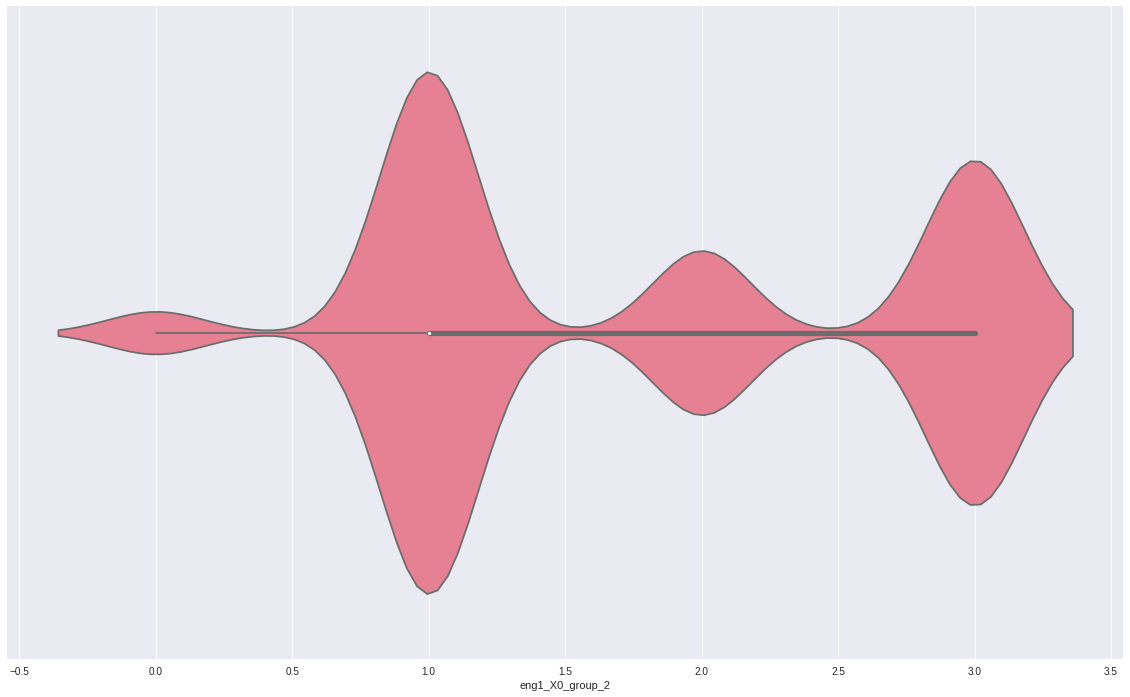

In [17]:
majorLocator = MultipleLocator(1) 
fig, ax = plt.subplots(figsize=(20,12))
ax.yaxis.set_major_locator(majorLocator)
sns.set_palette("husl")
sns.violinplot(x = test['eng1_X0_group_2'], jitter=True)

In [18]:
train.head()

,y,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X189,X190,X191,X192,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X221,X222,X223,X224,X225,X226,X227,X228,X229,X230,X231,X232,X233,X234,X235,X236,X237,X238,X239,X240,X241,X242,X243,X244,X245,X246,X247,X248,X249,X250,X251,X252,X253,X254,X255,X256,X257,X258,X259,X260,X261,X262,X263,X264,X265,X266,X267,X268,X269,X270,X271,X272,X273,X274,X275,X276,X277,X278,X279,X280,X281,X282,X283,X284,X285,X286,X287,X288,X289,X290,X291,X292,X293,X294,X295,X296,X297,X298,X299,X300,X301,X302,X304,X305,X306,X307,X308,X309,X310,X311,X312,X313,X314,X315,X316,X317,X318,X319,X320,X321,X322,X323,X324,X325,X326,X327,X328,X329,X330,X331,X332,X333,X334,X335,X336,X337,X338,X339,X340,X341,X342,X343,X344,X345,X346,X347,X348,X349,X350,X351,X352,X353,X354,X355,X356,X357,X358,X359,X360,X361,X362,X363,X364,X365,X366,X367,X368,X369,X370,X371,X372,X373,X374,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385,eng1_X0_group,eng1_X0_group_2
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,130.81,k,v,at,a,d,u,j,o,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,3
6,88.53,k,t,av,e,d,y,l,o,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
7,76.26,az,w,n,c,d,x,j,x,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0

In [19]:
train['eng1_bin_sum'] = train.iloc[:,9:377].apply(lambda x: np.sum(x), axis=1 )
test['eng1_bin_sum'] = test.iloc[:,8:376].apply(lambda x: np.sum(x), axis=1 )